<a href="https://colab.research.google.com/github/kb22/Tensorflow-Course/blob/master/Classification_of_Fashion_MNIST_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Fashion MNIST using CNN

In this notebook, I'll use a Convolutional Neural Network to train on the Fashion MNIST dataset and then classify amongst 10 different clothing items including shirt, sandel etc.

## Background

The Fashion MNIST dataset includes many images belonging to 10 different classes of clothing. These classes are:
- T-shirt/top
- Trouser
- Pullover
- Dress
- Coat
- Sandal
- Shirt
- Sneaker
- Bag
- Ankle boot

The dataset allows us to use deep learning models to train on the images and then use it to classify new set of images from these classes. Each image is of the size 28x28 pixels. Each pixel value is represented as a value from 0 to 255. 0 refers to black, 255 refers to white and the number in between refer to different shades of gray. All images are grayscale.

## Import libraries

I'll import tensorflow and other libraries. The Fashion MNIST dataset is available in `tensorflow_datatsets`.

In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_datasets as tfds

tf.enable_eager_execution()

I'll also set the logging to only log Tensorflow errors.

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Data retrieval

The `tensorflow_datasets` already has the MNIST dataset. So, the best way to get the data is from here itself.
The `tfds.load()` method is used to fetch the dataset.
- **name:** It is the name of the dataset that we want to download.
- **data_dir:** It defines the directory where we want to save/read the dataset to/from.
- **as_supervised:** It returns the labels along with the features so that we can perform supervised learning.
- **with_info:** It returns information about the dataset.

The complete list of datasets is available [here](https://www.tensorflow.org/datasets/datasets).

In [0]:
dataset, info = tfds.load(name = 'fashion_mnist', data_dir = 'data', as_supervised = True, with_info = True)

Let's first take a look at the information available with this dataset.

In [4]:
print("Dataset name: {}".format(info.name))
print("Dataset version: {}".format(info.version))
print("Description: {}".format(info.description))

Dataset name: fashion_mnist
Dataset version: 1.0.0
Description: Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.


There are 60,000 train images and 10,000 test images. Let's get those train and test data into separate variables.

In [0]:
train_dataset = dataset['train']
test_dataset = dataset['test']

## Exploring the data

I'll now take a look at a sample images from the training data by plotting the first 20 images. As the label from the dataset would be a number, I will create a `classes` variable that will include the names of all items in the correct order.

In [0]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

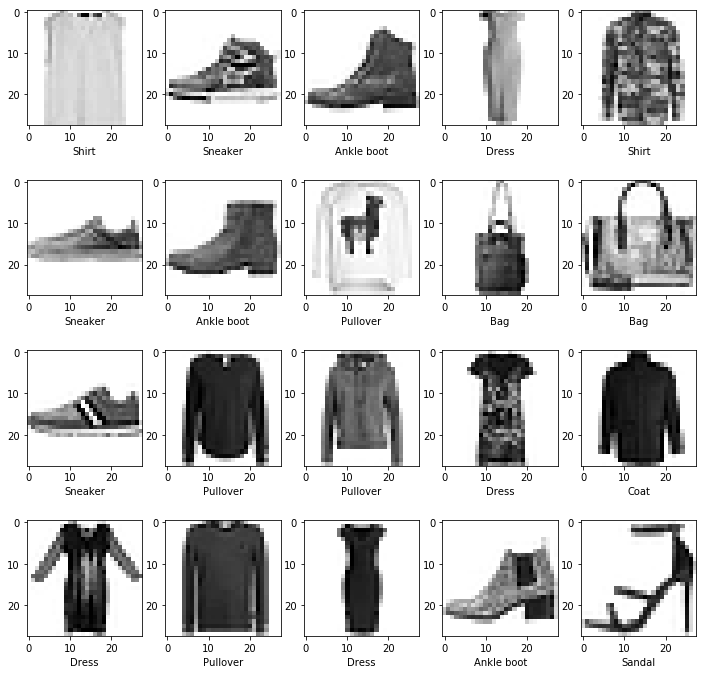

In [7]:
plt.figure(figsize = (12, 12))
index = 1

for image, label in train_dataset.take(20):
  image = tf.reshape(image, (28, 28))
  plt.subplot(4, 5, index)
  plt.imshow(image, cmap = plt.cm.binary)
  plt.xlabel(classes[label])
  index += 1

From the view point of a human, the images are quite clear. I'm able to distinguish and see what each of the images actually are. None of the images have a background to them. It appears that all images were taken on a white background. While this would be relatively easy, in real life, such objects would be colored and mixed with other items and different backgrounds. This would make the task more challenging and interesting.

## Processing the data

For working with deep learning models, it's always a good practice to normalize the dataset. Thus, I'll convert each pixel value from the range of [0, 255] to [0, 1]. On applying a `map`, we can apply a given method to all images in the dataset. Using this, I'll iterate over both the train and test dataset.

In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

## Building the model

The next step is to start with building the Convolutional Neural Network that can read an image as an input and then output a class to which it thinks the item belongs to.
I'll create the Neural Network with Flatten and Dense layers.

### Conv2D Layer
The convolutional layer creates a set of filters defined the filters parameter where the images are padded. This results in number of features equal to the number of filters for each image.

### MaxPooling2D
We can reduce the size of the image features generated from the Conv2D latey and still keep most of the information intact. Thus, by defining a specific stride and pool_size, we can pool the maximum value in each stride and reduce the size of the feature.

### Flatten Layer
This layer takes multi-dimensional array and converts it into a 1-D array.

### Dense Layer
The dense layer creates a fully connected layer in which all nodes in the present layer are connected to all nodes in the previous layer.

I'll create the Neural Network with 4 layers in total:
- **1 Conv2D layer:** The first layer is a convolutional layer with 32 filters and a kernel size of 3x3. I'll use the *relu* activation function.
- **1 MaxPooling layer:** It reduces the size of the image by keeping a stride of 2 with a pool_size of 2x2.
- **1 Conv2D layer:** I again add a convolutional layer with 64 filters and a kernel size of 3x3. I'll use the *relu* activation function.
- **1 MaxPooling layer:** It reduces the size of the image by keeping a stride of 2 with a pool_size of 2x2.
- **1 flatten layer:** It accepts the image features from the previous layer and converts its them into a 1D array.
- **2 Hidden layers:** These dense layers are fully connected with *relu activation function* and have 256 and 128 nodes respectively.
- **1 Output layer:** The final layer is the output layer with a *softmax activation function*. This emits the probability of each class for any given image and adds up to 1.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = tf.nn.relu, input_shape = (28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 256, activation = tf.nn.relu),
    tf.keras.layers.Dense(units = 128, activation = tf.nn.relu),
    tf.keras.layers.Dense(units = 10, activation = tf.nn.softmax)
])

Next, I'll compile the whole model using the following parameters:
- **optimizer:** It defines the optimizer to use when training the model to reduce the loss at each training cycle.
- **loss:** The loss function is defined to calculate how far off is the model at predicting the actual class of a given input.
- **metrics:** If we want to keep track of any metric, while training the model, we can define an array in this parameter.

In [0]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

## Trainnig the model

As the model is now ready, I can start with training the model. I'll train it for 10 epochs using a GPU. 

An essential trick I learnt is that we can use `repeat()` method to shuffle the dataset so that the model does not learn anything from the order of the images.

In [0]:
TRAINING_EXAMPLES_COUNT = 60000
BATCH_SIZE = 32
train_dataset_batched = train_dataset.repeat().shuffle(TRAINING_EXAMPLES_COUNT).batch(BATCH_SIZE)
test_dataset_batched = test_dataset.batch(BATCH_SIZE)

In [12]:
model.fit(train_dataset_batched, epochs = 10, steps_per_epoch = math.ceil(TRAINING_EXAMPLES_COUNT/BATCH_SIZE), verbose = 1)

Epoch 1/10
1875/1875 [==============================] - 50s 27ms/step - loss: 0.3907 - acc: 0.8576
Epoch 2/10
1875/1875 [==============================] - 35s 18ms/step - loss: 0.2508 - acc: 0.9080
Epoch 3/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2039 - acc: 0.9247
Epoch 4/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.1724 - acc: 0.9369
Epoch 5/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.1440 - acc: 0.9462
Epoch 6/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.1179 - acc: 0.9562
Epoch 7/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0981 - acc: 0.9642
Epoch 8/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0811 - acc: 0.9696
Epoch 9/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0710 - acc: 0.9735
Epoch 10/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0570 - acc: 0.9783


## Testing model

I'll start by testing the model on the test dataset and calculate both the test loss and test accuracy.

In [13]:
TESTING_EXAMPLES_COUNT = 10000
test_loss, test_accuracy = model.evaluate(test_dataset_batched, steps = math.ceil(TESTING_EXAMPLES_COUNT/BATCH_SIZE))
print("Test loss: {0:.4f}".format(test_loss))
print("Test accuracy: {0:.2f}%".format(test_accuracy*100))

313/313 [==============================] - 3s 11ms/step - loss: 0.3494 - acc: 0.9222
Test loss: 0.3494
Test accuracy: 92.22%


I was able to have a training accuracy of above 97% and a test accuracy of 92% which is definitely higher than the one I achieved with ANN. However, the difference between training and testing data is really high. This signals that our model might have overfit on the training data.

## Analysing results

Now that I have a trained model, let's see how it predicts about various input images using plots. If the prediction is same as the actual label, I'll color it as `green` else I'll color it as `red`.

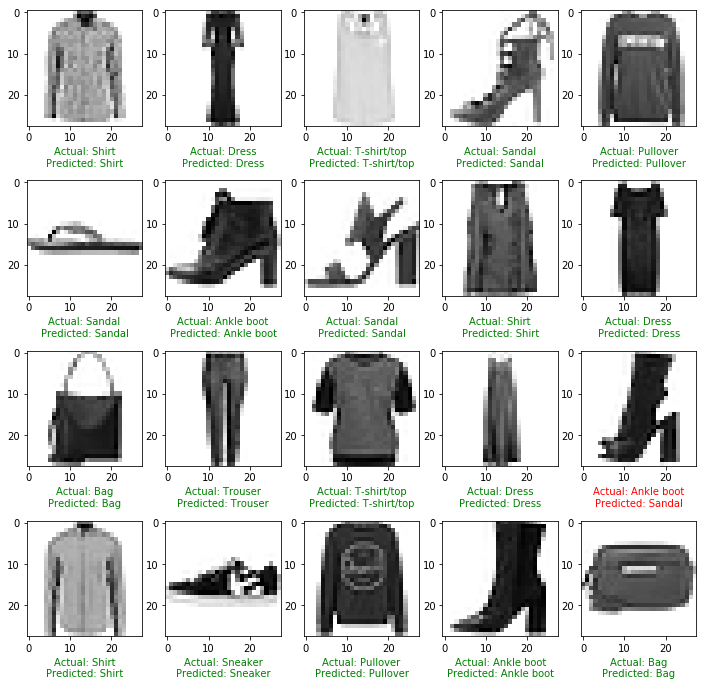

In [14]:
plt.figure(figsize = (12, 12))
index = 1

for image, label in test_dataset.take(20):
  prediction = model.predict(tf.reshape(image, (1, 28, 28, 1)))
  prediction = np.argmax(prediction[0])
  image = tf.reshape(image, (28, 28))
  
  plt.subplot(4, 5, index)
  plt.imshow(image, cmap = plt.cm.binary)
  if (classes[label] == classes[prediction]):
    plt.xlabel('Actual: ' + classes[label] + '\nPredicted: ' + classes[prediction], color = 'green')
  else:
    plt.xlabel('Actual: ' + classes[label] + '\nPredicted: ' + classes[prediction], color = 'red')
  index += 1

Out of the 20 items above, the model correctly predicted 19 items.